<img src="https://stijl.kuleuven.be/releases/latest/img/svg/logo.svg" alt="KU Leuven">

# **Exploring *CroALa* and Marko Marulić**

An exam project for Scripting Languages.

<div class="alert alert-block alert-danger">

<b> THIS NOTEBOOK IS A WORK IN PROGRESS </b>

</div>

This is a Juypter notebook for the exam project for the [Scripting Languages \[G0W95B\]](https://onderwijsaanbod.kuleuven.be/2025/syllabi/e/G0W95BE.html) course of the [Digital Humanities](https://www.kuleuven.be/programmes/master-digital-humanities) programme at [KU Leuven](https://www.kuleuven.be/english/kuleuven/). 

Author:
<br> Petar Soldo
<br> r1076709
<br> [petar.soldo@student.kuleuven.be](mailto:petar.soldo@student.kuleuven.be)

## About the project

The main goal of the project is to perform an "exploratory analysis of data" and "to (...) independently apply the programming techniques explored during the course".

For this purpose, *CroALa* was chosen as a dataset to be analyzed. 

The project has two main goals.

1. Perform a short analysis of the documents in _CroALa_ based on their metadata.
2. Perform a short text analysis of selected works by Marko Marulić.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Marko_Marulic_bust_-_lighting_fix.jpg/250px-Marko_Marulic_bust_-_lighting_fix.jpg" alt="Marko Marulić">

*Bust of Marko Marulić of Split, Croatian poet, by Ivan Meštrović*

*DIREKTOR (talk · contribs), CC0, via Wikimedia Commons*

## *CroALa*

### About *CroALa*

CroALa (*Croatiae auctores Latini*) is "a digital collection of texts by Croatian Latin authors, and by authors somehow connected with people and region of today's Croatia" [\(source\)](https://www.ffzg.unizg.hr/klafil/dokuwiki/doku.php/z:croala-qui-quid). 

The texts of the collection are formated as [TEI encoded](https://www.tei-c.org/release/doc/tei-p5-doc/en/html/index.html) XML files. These files can be found, together with various scripts and some other data, on a [dedicated GitHub repository](https://github.com/nevenjovanovic/croatiae-auctores-latini-textus).

The files of the texts are generally divided into the `<teiHeader>` element, containing metadata about a text, and the `<text>` element containing mainly the text itself. For the first part of the project, we will use data found in the `<teiHeader>` element. The general scheme used to create these files can be found in the [`croala-template-2024.xml`](https://github.com/nevenjovanovic/croatiae-auctores-latini-textus/blob/master/croala-template-2024.xml) file, although it is important to note that **not all files are structured completely identically** so we should keep an eye on possible differences.

### What do I want to do?

I want to build a table with the metadata from the XML files in the repository.

To do this I will make a small piece of code that (i) opens every file and extracts the data we need to a list, (ii) appends the list to a dictionary, (iii) turns the dictionary to a *Pandas* dataframe and (iv) exports the dataframe to CSV file. 

The data I want in my table is:
- name of the file
- title of the work
- name of the first author mentioned in the list of authors
- date related to the author mentioned first
- all listed authors and appurtenant dates
- editors of the edition
- languages attributed to the document
- date(s) of creation
- place(s) of creation
- typus
- genres
- (literary) period

### Retrieving metadata about the documents

**NOTE**: This part of the project was largely based on the blog post [*Parsing TEI XML documents with Python*](https://komax.github.io/blog/text/python/xml/parsing_tei_xml_python/) by Maximilian Konzack (2019).

First, let's import all the libraries we need.

In [48]:
# BeaurifulSoup and lxml for XML parsing
from bs4 import BeautifulSoup 
import lxml
# glob and os.path for file manipulations
from glob import glob
from os.path import basename
# pprint to see the results better
from pprint import pprint
# pandas for data analysis
import pandas as pd
# re for regex
import re
# seaborn for data visualisation
import seaborn as sns
# requests for accessin APIs
import requests
from io import StringIO

We define two functions:
1. *read_tei* for reading the files and
2. *e2t*, short for *element to text*, for extracting the text from an XML element.

Both of these functions were slightly adapted from the aforementioned project: https://komax.github.io/blog/text/python/xml/parsing_tei_xml_python/.

In [2]:
# Take an XML file and return it as a BeutifulSoup object
def read_tei(tei_file):
    with open(tei_file, 'r', encoding = 'utf-8') as tei:
        soup = BeautifulSoup(tei, 'xml')
        return soup
# We can use this new object to navigate the XML document

In [3]:
# Take an XML element and return just its contents
def e2t(elem, default=''):
    if elem:
        return re.sub(r'\s+', ' ', elem.getText(strip=True)) 
        # The regular expression is used to avoid often occuring multiple whitespaces
        # and unsual line breaks, not removed by (strip=True)
    else:
        return default

### Extracting the elements

We can shortly demonstrate how this works. We will choose the first document from the *"texts"* directory.

Let's extract some simple metadata from it.

In [4]:
#This loads the document:
document = read_tei("txts/aa-vv-carm-occ-vd.xml")

#This finds the title:
print(e2t(document.find("title")))

#This finds the (first) author:
print(e2t(document.find("author")))

#This finds the creation date:
print(e2t(document.select_one("profileDesc creation date")))

Carmina occasionalia e codice Traguriensi Variorum Dalmaticorum, versio electronica
Auctores varii
1565-1650


Sometimes, there is more than one piece of information we want to extract from an XML element. It seems that *BeutifulSoup* always returns a list in this case. It is important to not that the `getText()` method does not work on a list, so, if we wish to extract the text from multiple elements, we must iterate throught them.

In [5]:
for author in document.select("titleStmt author"):
    print (e2t(author))

Auctores varii
Grauisius, Iacobus
Mladinić, Sebastijan1561/1563 - 1620-21
Mazarelli, Valerio
Statilić, Marinc. 1650
Pridojević, Ivanc. 1600
Vranius
Gaudentius
Matthaeus Desseus Ragusinus
Michael Racetinus


At first I thought of using the `find` and `find_all` methods, but it seems that `select` and `select_one` allow defining a path by simply writing the elements, separated by a whitespace. This would require chaining the methods when using `find/find_all`.

Thus the selection of all the `author` elements above, using `find_all` would look like this: `document.find("titleStmt").find_all("author")`. The `select(_one)` methods also have a nicer way to access an attribute value.

I thus find the CSS selector methods (`select/select_one`) much more elegant and sufficiently useful for this part of the project.

More about this issue:
- https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors-through-the-css-property
- https://stackoverflow.com/a/38033910

### Checking how elements behave

Before we go on to extracting the metadata, we should first check what do some of our elements look like. I was forced to perform this check *after* I started buidling a table, because I realized I was not extracting information I wanted or thought I was. However, I will, providently, explain what I checked for and how I did it before going on :)

The elements which needed inspecting were `author` and `creation`. They sometimes encode information in different ways, i.e. by using different tags.

We will first inspect the `author` and `creation` tag. We do this by making use of the `name` method to find the names of the child elements of the `author` element. The follwoin code iterates through the directory and stores all a tagnames to a list first, and then turns list into a set to leave us with unique values only.

In [6]:
tagnames_author = []
tagnames_creation = []

# Iterate through documents and save all tag names to the tagnames list.
for filename in glob("txts/*.xml"):
    doc = read_tei(filename)
    #We check if the element we want exists
    if doc.select_one("titleStmt author"):
        for element in doc.select_one("titleStmt author"):
            tagnames_author.append(element.name)
    else:
        tagnames_author.append('')

    if doc.select_one("profileDesc creation"):
        for element in doc.select_one("profileDesc creation"):
            tagnames_creation.append(element.name)
    else:
        tagnames_creation.append('')

In [7]:
# Make a set to leave only unique values
tagset_author = set(tagnames_author)
tagset_creation = set(tagnames_creation)
print(f"Tags appearing in children of the 'author' element are: {tagset_author} and tags appearing in children of the 'creation' element are {tagset_creation}.")

Tags appearing in children of the 'author' element are: {None, 'persName', 'date', '', 'orgName', 'placeName', 'ref'} and tags appearing in children of the 'creation' element are {None, 'address', 'date', 'placeName'}.


We now have a list (a set to be more precise) of all tags which appear as chidren of the `author` and `creation` tag. We go on further to inspect in which files do these tags appear and what do they contain.

In [8]:
# Create lists to store the elements we want to inspect
# Elements of author
ref= []
placeName = []
orgName = []

# Elements of creation
address_c = []
placeName_c = []


for file in glob("txts/*.xml"):
    doc = read_tei(file)
    # Find the elemenets and store the to list, together with the filename
    # Elements of author
    if doc.select_one("titleStmt author ref"):
        ref.append([file, doc.select_one("titleStmt author ref")])
    if doc.select_one("titleStmt author placeName"):
        placeName.append([file, doc.select_one("titleStmt author placeName")])
    if doc.select_one("titleStmt author orgName"):
        orgName.append([file, doc.select_one("titleStmt author orgName")])
    # Elements of creation
    if doc.select_one("profileDesc creation address"):
        address_c.append([file, doc.select_one("profileDesc creation address")])
    if doc.select_one("profileDesc creation placeName"):
        placeName_c.append([file, doc.select_one("profileDesc creation placeName")])

We can now see what type of data these tags marks contain and in which file we can find them. This can further on be used to indeed inspect the files and decide how to extract the data.

In [9]:
pprint(ref[:3])
pprint(placeName[:3])
pprint(orgName[:3])
pprint(address_c[:3])
pprint(placeName_c[:3])

[['txts\\andreis-f-1529-02-15.xml',
  <ref target="http://www.wikidata.org/entity/Q16115490" type="wikidata">Andreis, Franjo Trankvil</ref>],
 ['txts\\cikulin-if-ideae.xml',
  <ref target="http://www.wikidata.org/entity/Q860595">Čikulin, Ivan Franjo</ref>],
 ['txts\\donat-mandel-sissiensis.xml',
  <ref target="donat01">Donati, Ivan</ref>]]
[['txts\\barletius-scodrensi-obsidione-1504.xml',
  <placeName>Skadar</placeName>],
 ['txts\\barletius-vita-castrioti-1508.xml', <placeName>Skadar</placeName>],
 ['txts\\goineo-gb-situistriae-1543.xml', <placeName>Piran</placeName>]]
[['txts\\aa-vv-carm-occ-vd.xml',
  <orgName ref="#varii-1650">Auctores varii</orgName>],
 ['txts\\aa-vv-epigr-mulla.xml',
  <orgName ref="#varii-1552">Auctores varii</orgName>],
 ['txts\\aa-vv-epigr-tres.xml',
  <orgName ref="#varii-1600">Auctores varii</orgName>]]
[['txts\\aa-vv-carmina-vgc.xml',
  <address>
<addrLine>Romae</addrLine>
<addrLine>Ragusae</addrLine>
</address>],
 ['txts\\andreis-f-philos.xml',
  <address>


### Making a table out of the metadata

We can finally make a table out of the metadata. We initialize a list `croala_data` to which we will append a dictionary of values corresponding to the metadata for every XML file in our `txts` directory. This list of dictionaries is  then used to create a Panadas dataframe. In the end, we dump it to a csv file.

In [10]:
croala_data = []

for filename in glob("txts/*.xml"):
    doc = read_tei(filename)
    
    # Extract titles
    titles = e2t(doc.select_one("titleStmt title"))

    # Extract first author name
    if doc.select_one("titleStmt author"):
        if doc.select_one("titleStmt author").find("orgName"):
            first_author = e2t(doc.select_one("titleStmt author orgName"))
        elif doc.select_one("titleStmt author").find("persName"):
            first_author = e2t(doc.select_one("titleStmt author persName"))
    else:
        first_author = ''

    #Extrat first author date
    if doc.select_one("titleStmt author"):
        first_author_date = e2t(doc.select_one("titleStmt author").find("date"))
    else:
        first_author_date = ''
    
    # Extract all authors
    all_authors = [(re.sub(r'\s+', ' ', a.get_text(separator = "; ", strip=True))) for a in doc.select("author")]

    # Extract editors
    editors = [e2t(e) for e in doc.select("titleStmt editor persName ref")]

    # Extract language
    language = [l["ident"] for l in doc.select("profileDesc langUsage language")]

    # Extract place
    if doc.select_one("profileDesc creation"):
        if doc.select("profileDesc creation placeName"):
            place = [e2t(pl) for pl in doc.select("profileDesc creation placeName")]
        elif doc.select_one("profileDesc creation address"):
            place = [e2t(add) for add in doc.select("profileDesc creation addrLine")]
        else:
            place = ''
    else:
        place = ''

    # Extract date
    date = [e2t(d) for d in doc.select("profileDesc creation date")]

    # Extract typus
    typus = e2t(doc.select_one("textClass keywords[scheme=typus] term"))

    # Extract genres
    genres = [e2t(g) for g in doc.select("textClass keywords[scheme=genre] term")]

    # Extract period
    for ae in doc.select("textClass keywords[scheme=aetas]"):
        period = [e2t(term) for term in ae.select("term")]

    # Append as a dictionary
    croala_data.append({
        "filename": basename(filename),
        "titles": titles,
        "first_author": first_author,
        "first_author_date": first_author_date,
        "all_authors": all_authors,
        "editors": editors,
        "language": language,
        "date": date,
        "place": place,
        "typus": typus,
        "genres": genres,
        "period": period
    })

# Convert to a dataframe
croala_df = pd.DataFrame(croala_data)
croala_df.head()

,filename,titles,first_author,first_author_date,all_authors,editors,language,date,place,typus,genres,period
0,aa-vv-carm-occ-vd.xml,Carmina occasionalia e codice Traguriensi Vari...,Auctores varii,,"[Auctores varii, Grauisius, Iacobus, Mladinić,...",[Neven Jovanović],[lat],[1565-1650],,poesis,"[poesis - epigramma, poesis - elegia]","[Litterae renatae (1400-1600), Saeculum 16 (15..."
1,aa-vv-carmina-vgc.xml,Carmina minora ex libro De vita et gestis Chri...,"Bunić, Jakov",1469-1534,"[Bunić, Jakov; 1469-1534, Caluus, Hieronymus; ...",[Neven Jovanović],[lat],[a. 1502--1526],"[Romae, Ragusae]",poesis,"[poesis - carmen, poesis - epigramma, poesis -...","[Litterae renatae (1400-1600), Saeculum 16 (15..."
2,aa-vv-epigr-mulla.xml,Ad clarissimum uirum dominum Benedictum de Mul...,Auctores varii,,"[Auctores varii, Martinčić, Jerolim, Alberti, ...",[Neven Jovanović],[lat],[1549-1552],,poesis,"[poesis - epigramma, poesis - encomium]","[Litterae renatae (1400-1600), Saeculum 16 (15..."
3,aa-vv-epigr-natal.xml,"Epigrammata in codice Natalis, versio electronica","Kabalin, Grgur",,"[Kabalin, Grgur, Tolimerić, Ilija; m. 1537?]",[Miroslav Marcovich],[lat],[post 1536],,poesis,"[poesis - carmen, poesis - elegia, poesis - ep...","[Litterae renatae (1400-1600), Saeculum 16 (15..."
4,aa-vv-epigr-tres.xml,"Tres invicem epigrammata, versio electronica",Auctores varii,,"[Auctores varii, Kabalin, Grgur, Chrysogonus]",[Neven Jovanović],[lat],[c. 1600.],,poesis,[poesis - epigramma],"[Litterae renatae (1400-1600), Saeculum 16 (15..."


### Adding (missing) wordcounts

If we inspect other directories, we can see that the `varia` directory (created in my fork from various files found in the original repository's root) contains a wordcount file, name `croala-wordcounts.xml`. We will add the wordcounts to our dataframe.

This file contains elements, each with the name of the file and the wordcount as attributes. Let's inspect it.

In [11]:
wordcount_doc = read_tei("varia/croala-wordcounts.xml")

print(f"Length of wordcounts: {len(wordcount_doc.select("doc"))}. Length of croala_df filename column: {len(croala_df["filename"])}")

Length of wordcounts: 569. Length of croala_df filename column: 573


We see that there are less elements (and thus documents) in the wordcount file than in our table. Let's see which files are missing. 

We will create a set of filenames appearing in the wordcount file (there they are called "titles") and a set of the `filename` column of our `croala_df`. We can then just subtract the smaller set from the larger and what will remain are the files not covered in the wordcount document.

In [12]:
wc_titles = [wct["title"] for wct in wordcount_doc.select("doc")]
df_filenames = croala_df["filename"].values.tolist()
len(wc_titles)
missing_files = set(df_filenames) - set(wc_titles)
print (missing_files)

{'vrancic-a-epist-1540-03-28.xml', 'vrancic-a-epist-1540-07-28.xml', 'vrancic-a-epist-1540-10-12.xml', 'vrancic-a-epist-1534-11-06.xml'}


If we snoop about the repository, we realize these files do not have a word count because they were added after the word count file was made (this text is being written on 19/12/2025).

We can easily find this information ourselves (and it's a nice small exercise). The simplest way to do this would be to feed the text of the files to a Python library and have it tokenize them. But for consistency's sake, we will use the same method used for the rest of the files. This means using regular expressions to separate tokens.

The regular expression used for token separation can be found in "scripts/xsl/croala-kay-wordcount.xsl", an XSL script calculating the wordcount, and looks like this: `(\W|[0-9])+`. Note that '+ 1' is added to the total count.

You can see the complete file in the original repository [here](https://github.com/nevenjovanovic/croatiae-auctores-latini-textus/blob/master/scripts/xsl/croala-kay-wordcount.xsl).

We use the same regex for our four missing files. We iterate through them, extract just the text, tokenize it and count their length. We then create a dictionary where filenames are keys and word counts are values.

In [13]:
missing_wordcounts = {}
for filename in missing_files:
    miss_doc = read_tei(f"txts/{filename}")
    
    # Create a list of tokens by spliting the text element on the regex and excluding the whitespace(' ')
    tokens = [t for t in re.split(r'(\W|[0-9])+', e2t(miss_doc.find("text"))) if t!=' ']
    wordcount = len(tokens) + 1

    missing_wordcounts[filename]= wordcount

pprint(missing_wordcounts)

{'vrancic-a-epist-1534-11-06.xml': 466,
 'vrancic-a-epist-1540-03-28.xml': 370,
 'vrancic-a-epist-1540-07-28.xml': 286,
 'vrancic-a-epist-1540-10-12.xml': 539}


We now make a dictionary in the same style with the filenames and wordcounts from the `wordcount_doc`. We then update it (using the `.update()` method) to add the four elements from the `missing_wordcounts` dictionary.

In [14]:
wordcount = {}

for doc in wordcount_doc.select("doc"):
    wordcount_filename = doc['title']
    wordcount_wc = doc['wc']
    wordcount[wordcount_filename] = wordcount_wc

#Updating the wordcount with elements from the missing_wordocunts
wordcount.update(missing_wordcounts)

for i in list(wordcount.keys())[:4]:
    print(i, wordcount[i])

aa-vv-carm-occ-vd.xml 1260
aa-vv-carmina-vgc.xml 2865
aa-vv-epigr-mulla.xml 921
aa-vv-epigr-natal.xml 644


We can now add a "word_count" column by using the `map()` method. We use the lambda function to make sure that all values are treated as integers, because it will otherwise give us headaches in later analysis.

In [15]:
croala_df['word_count'] = (croala_df['filename'].map(wordcount)).apply(lambda x: int(x))

In [16]:
croala_df

,filename,titles,first_author,first_author_date,all_authors,editors,language,date,place,typus,genres,period,word_count
0,aa-vv-carm-occ-vd.xml,Carmina occasionalia e codice Traguriensi Vari...,Auctores varii,,"[Auctores varii, Grauisius, Iacobus, Mladinić,...",[Neven Jovanović],[lat],[1565-1650],,poesis,"[poesis - epigramma, poesis - elegia]","[Litterae renatae (1400-1600), Saeculum 16 (15...",1260
1,aa-vv-carmina-vgc.xml,Carmina minora ex libro De vita et gestis Chri...,"Bunić, Jakov",1469-1534,"[Bunić, Jakov; 1469-1534, Caluus, Hieronymus; ...",[Neven Jovanović],[lat],[a. 1502--1526],"[Romae, Ragusae]",poesis,"[poesis - carmen, poesis - epigramma, poesis -...","[Litterae renatae (1400-1600), Saeculum 16 (15...",2865
2,aa-vv-epigr-mulla.xml,Ad clarissimum uirum dominum Benedictum de Mul...,Auctores varii,,"[Auctores varii, Martinčić, Jerolim, Alberti, ...",[Neven Jovanović],[lat],[1549-1552],,poesis,"[poesis - epigramma, poesis - encomium]","[Litterae renatae (1400-1600), Saeculum 16 (15...",921
3,aa-vv-epigr-natal.xml,"Epigrammata in codice Natalis, versio electronica","Kabalin, Grgur",,"[Kabalin, Grgur, Tolimerić, Ilija; m. 1537?]",[Miroslav Marcovich],[lat],[post 1536],,poesis,"[poesis - carmen, poesis - elegia, poesis - ep...","[Litterae renatae (1400-1600), Saeculum 16 (15...",644
4,aa-vv-epigr-tres.xml,"Tres invicem epigrammata, versio electronica",Auctores varii,,"[Auctores varii, Kabalin, Grgur, Chrysogonus]",[Neven Jovanović],[lat],[c. 1600.],,poesis,[poesis - epigramma],"[Litterae renatae (1400-1600), Saeculum 16 (15...",257
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,zamagna-b-odyssea.xml,"Homeri Odyssea Latinis versibus expressa, vers...",Homerus,,"[Homerus, Zamanja, Bernard; 1735-1820]",[Petra Šoštarić],[lat],[1777],,poesis,"[poesis - versio, poesis - epica, poesis - ele...","[Litterae recentiores (1600-1850), Saeculum 18...",95483
569,zamagna-b-osmanidos.xml,"Osmanidos fragmentum, versio electronica","Gundulić, Ivan",1588-1638,"[Gundulić, Ivan; 1588-1638, Zamanja, Bernard; ...",[Neven Jovanović],[lat],[ante 1820],,poesis,"[poesis - versio, poesis - epica, poesis - fra...","[Litterae recentiores (1600-1850), Saeculum 18...",199
570,zavorovic-d-inscriptio.xml,"Inscriptio in aede, versio electronica","Zavorović, Dinko",1540-1608,"[Zavorović, Dinko; 1540-1608]",[Iva Kurelac],[lat],[c. 1600],,prosa,[prosa oratio - inscriptio],"[Litterae recentiores (1600-1850), Saeculum 17...",14
571,zigerius-e-epist.xml,"Epistola cuiusdam pii concionatoris, ex Turcia...","Vlačić Ilirik, Matija",1520-1575,"[Vlačić Ilirik, Matija; 1520-1575, Zigerius, E...",[Stanko Andrić],[lat],[1549-1550],"[Tolna, Magdeburg]",prosa,"[prosa oratio - epistula, poesis - epigramma]","[Litterae renatae (1400-1600), Saeculum 16 (15...",1772


In [17]:
#Export to a csv file
croala_df.to_csv("croala_metadata.csv", index = False, encoding = 'utf-8')

### Exploring the data

We can now explore and visualise the data in our table, using Pandas functions and descriptive statistics.

Let's start with some simple searches first. Here is the total number of authors in the `first_author` column, top ten first authors and a bar chart with top 20 first authors.

There are 217 distinct authors mentioned in the 'first_author' column.

 first_author
Marulić, Marko              33
Vrančić, Antun              33
Anonymus                    25
Andreis, Franjo Trankvil    23
Brodarić, Stjepan           22
Škrlec Lomnički, Nikola     19
Ritter Vitezović, Pavao     14
Vrančić, Mihovil            14
Beneša, Damjan              11
Sobota, Ivan                10
Name: count, dtype: int64

 Axes(0.125,0.11;0.775x0.77)


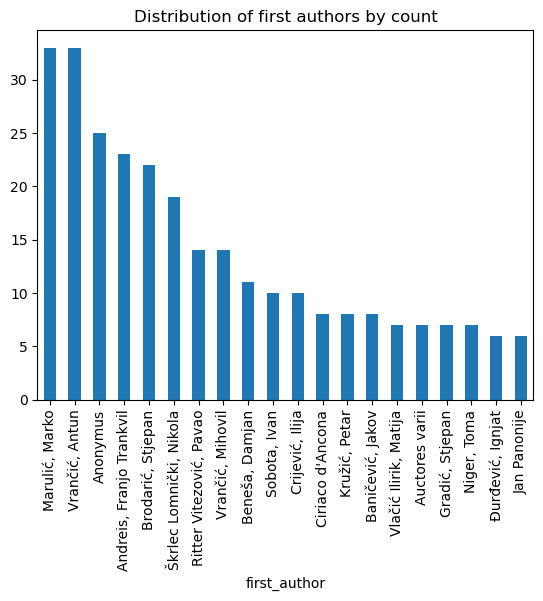

In [18]:
# Counting unique values in the 'first_author' column.
print (f"There are {croala_df["first_author"].nunique()} distinct authors mentioned in the 'first_author' column.")

# Printing ten topmost values by count in the 'first_author' column.
print ("\n", croala_df["first_author"].value_counts().head(10))

# Barchart with 20 topmost first authors.
print("\n", croala_df["first_author"].value_counts().head(20).plot(kind="bar", title="Distribution of first authors by count"))

We can also explore simple statistics for the "typus" value, i.e. what are the ratios of prose vs. poetry.

typus
prosa           344
poesis          228
prosa oratio      1
Name: count, dtype: int64

 Axes(0.22375,0.11;0.5775x0.77)


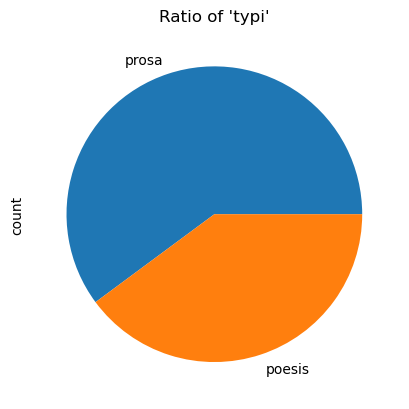

In [19]:
typus_count = croala_df["typus"].value_counts()
print (typus_count)
print ("\n", typus_count.head(2).plot(kind="pie", title="Ratio of 'typi'"))

Let's do basic descriptive statistics for wordcount.

In [20]:
# Sum of all word counts in the repository.
print (f'There are {(croala_df["word_count"]).sum()} words in total in the repository.')
# Mean word count
print (f'An average document has around {round(croala_df["word_count"].mean())} words.')

# Find the maximum and miminum value in the word_count column.
max_wc = (croala_df["word_count"]).max()
min_wc = (croala_df["word_count"]).min()

# Locate the document with the min/max wordcount by indexes using 'idxmax()'/'idxmin()' - title is column 1
max_wc_doc = croala_df.iloc[(croala_df["word_count"]).idxmax(), 1]
min_wc_doc = croala_df.iloc[(croala_df["word_count"]).idxmin(), 1]


print(f"Document with the lowest word count is '{min_wc_doc}' with {min_wc} words.", 
      "\n",
      f"Document with the highest word count is '{max_wc_doc}' with {max_wc} words.")

There are 5819338 words in total in the repository.
An average document has around 10156 words.
Document with the lowest word count is 'Janci Alberti inscriptio, versio electronica' with 6 words. 
 Document with the highest word count is 'Clavis scripturae sacrae, pars prima (1580-1581), versio electronica' with 799605 words.


Earlier, we had a look at the first authors by the number of documents. Now, by using the `groupby` and `sum` methods we can calculate each of the first author's word count. We will inspect and visualize top 20 most authors.

first_author
Vlačić Ilirik, Matija        1237635
Marulić, Marko                921827
Škrlec Lomnički, Nikola       289429
Stay, Benedikt                266188
Krčelić, Baltazar Adam        265220
Homerus                       221483
Kunić, Rajmund                184300
Beneša, Damjan                126971
Crijević Tuberon, Ludovik     124532
Vičić, Kajetan                117847
Ritter Vitezović, Pavao       104839
Bošković, Ruđer               102801
Barić, Adam Adalbert           91759
Nikola Modruški                89756
Ferić Gvozdenica, Đuro         83542
Bunić, Jakov                   79211
Kitonić, Ivan                  69142
Auctores varii                 67698
Andreis, Franjo Trankvil       67037
Rogačić, Benedikt              66387
Name: word_count, dtype: int64

 Axes(0.125,0.11;0.775x0.77)


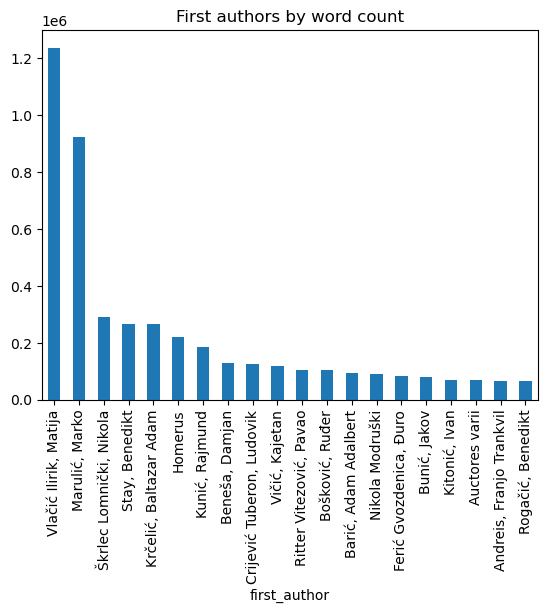

In [21]:
# Sum the word count for each first author and return 20 largest values.
first_author_wc = croala_df.groupby("first_author")['word_count'].sum()
print(first_author_wc.nlargest(20))

# Make a barchart of the count above.
print("\n", first_author_wc.nlargest(20).plot(kind="bar", title="First authors by word count"))

We can perform the same inspection for the 'typus' column.

typus
poesis          2035002
prosa           3783682
prosa oratio        654
Name: word_count, dtype: int64

 Axes(0.22375,0.11;0.5775x0.77)


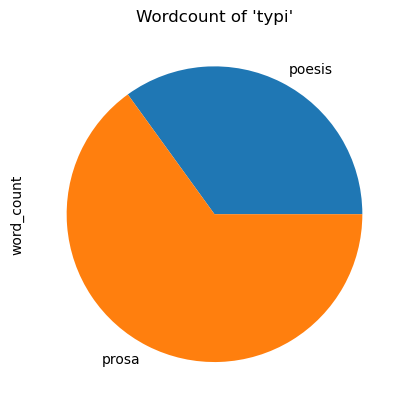

In [22]:
typus_wc = croala_df.groupby("typus")['word_count'].sum()
print(typus_wc)
print ("\n", typus_wc.head(2).plot(kind="pie", title="Wordcount of 'typi'"))

### Exploring places

We first inspected just the first author column, because it containst just one value. We will now try to see if we can extract data from other columns, which store multiple values per cell as a list. These are columns like `all_authors`, `place`, `period` and `genre`.

All of these lists need to be iterated somehow. We will make use of the Pandas `explode()` method, which expands the lists found in cells in such a way that each of the elements of the list is placed in a new row, but with other cells and the row index remaining the same. This part of the project was partially inspired by [this post by Max Hilsdorf (2020)](https://medium.com/data-science/dealing-with-list-values-in-pandas-dataframes-a177e534f173).

We can first inspect all the places listed in our table. We will represent the top 10 places being mentioned. Notice that the most common place is an empty value (simply because most documents don't have a place stated) so we will ommit it from the graph.

place
              270
Dubrovnik      39
Split          33
Zagreb         26
Trogir         20
Buda           20
Rome           19
Alba Iulia     17
Zadar          15
Jakovlje       12
Name: count, dtype: int64 

Axes(0.125,0.11;0.775x0.77)


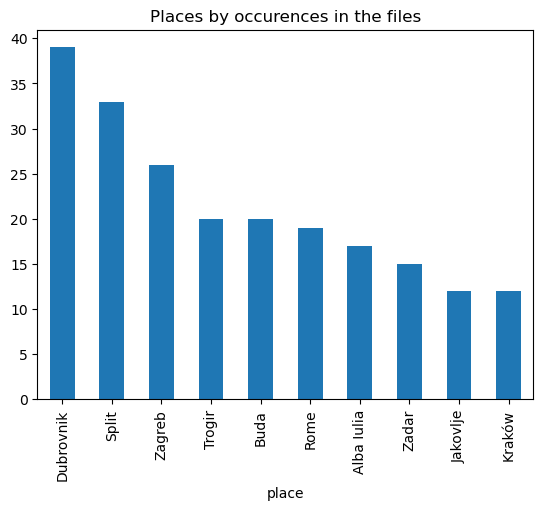

In [23]:
places_count = croala_df["place"].explode().value_counts()
print (places_count.nlargest(10), "\n")
print(places_count[1:].nlargest(10).plot(kind="bar", title="Places by occurences in the files"))

### Exploring genres

We can do the same things with genres.

genres
prosa oratio - epistula     474
poesis - epigramma          114
poesis - elegia              76
poesis - carmen              51
poesis - epica               45
prosa oratio - oratio        36
poesis - epistula            35
prosa oratio - tractatus     25
prosa oratio - historia      23
poesis - inscriptio          20
Name: count, dtype: int64 

Axes(0.125,0.11;0.775x0.77)


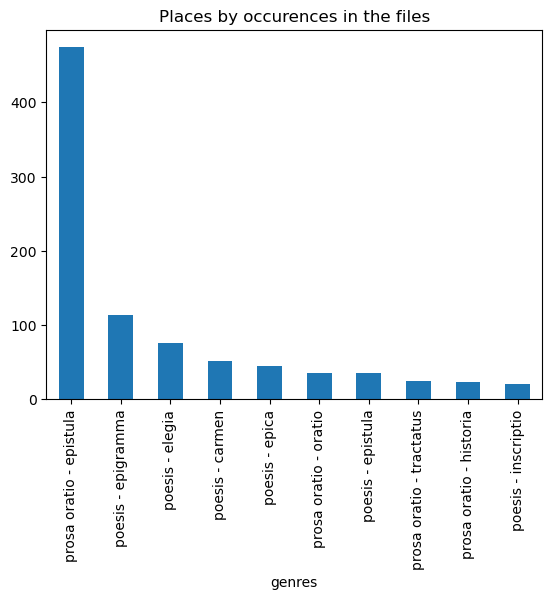

In [24]:
genres_count = croala_df["genres"].explode().value_counts()

print (genres_count.nlargest(10), "\n")
print(genres_count.nlargest(10).plot(kind="bar", title="Places by occurences in the files"))

### Exploring periods

We can perform a similar check for the `period` column. The problem with this column is that it contains lots of different representation of periods. Look at what happens when we extract all unique values in this column.

In [25]:
croala_df["period"].explode().unique()

array(['Litterae renatae (1400-1600)', 'Saeculum 16 (1501-1600)',
       '1551-1600', 'Litterae recentiores (1600-1850)',
       'Saeculum 17 (1601-1700)', '1601-1650', '1501-1550',
       'Litterae medii aevi (700-1400)', 'Saeculum 11 (1001-1100)',
       '1051-1100', 'Saeculum 12 (1101-1200)', '1101-1150',
       'Saeculum 15 (1401-1500)', '1451-1500', 'Saeculum 15',
       'Saeculum 16', '1001-1050', 'Saeculum 19 (1801-1900)', '1801-1850',
       'Saeculum 14 (1301-1400)', 'Saeculum 18 (1701-1800)', '1751-1800',
       'Saeculum 15 (1501-1600)', '1651-1700', '1701-1750',
       'Saeculum 19 (1801-1850)', 'Litterae novissimae (1850-2000)',
       'Saeculum 20 (1901-2000)', '1901-1950', '1851-1900', '1401-1450',
       '1800-1850', 'Medium aevum (700-1400)', '1351-1400', '1401-1500',
       'Litterae recentiores (1601-1800)', 'Saeculum 13 (1201-1300)',
       '1251-1300', '1951-2000', 'Saeculum 18 (1751-1800)', '1301-1350',
       '1450-1500', 'litterae renatae', 'latinitas recentior'

There are three main types (and some others) of period notation: (i) ones containing 'Litterae', representing a litterary period, (ii) ones containing 'Saeculum' representing the century and (iii) ones containing just years in yyyy-yyyy format, representing evey half of a century. Notice that some of them differ due to inconsistent notation (e.g. 'Litterae recentiores (160**0**-1800)' vs. Litterae recentiores (160**1**-1800)') or annotation errors (e.g. 'Saeculum **17** (**1501-1600**)').

To fix this, we will first explode the `periods` column and save it to the a `period` variable. We will then perform a series of replacement methods to correct wrong values. We always change the values with a smaller count to the ones with a greater count. There are some other assumptions made while correcting, but these should not affect the results greatly. 

In [86]:
periods = croala_df["period"].explode()

# When multiple values need to be replaced by one value, we use separate replace methods and lists
periods = periods.replace(['Litterae recentiores (1600-1800)', 'Litterae recentiores (1601-1800)'], 'Litterae recentiores (1600-1850)')
periods = periods.replace(['Saeculum 15', 'Saeculum 15 (1501-1600)'], 'Saeculum 15 (1401-1500)')
periods = periods.replace(['Saeculum 17 (1501-1600)', 'Saeculum 17 (1600-1700)'], 'Saeculum 17 (1601-1700)')
# All cases when a single value is replaced by a single value are placed in a single replace statment and formed as a dictionary
periods = periods.replace({
    'Litterae medii aevi (600-1400)': 'Litterae recentiores (1600-1850)', 
    'Litterae novissimae (1800-1850)': 'Litterae novissimae (1850-2000)',
    'Saeculum 16': 'Saeculum 16 (1501-1600)',
    'Saeculum 18 (1751-1800)': 'Saeculum 18 (1701-1800)',
    'Saeculum 19 (1801-1850)': 'Saeculum 19 (1801-1900)'
                          })

We want to count the values for each of the periods and then select them by first searching for all 'Litterae' periods, then all 'Saeculum' periods etc. How do we do this? When we use the `value_counts()` method on our exploded column, a Pandas `Series` object is returned with the periods as indices and counts as values. We can then filter different period notations by specifying what the index looks like (using the `contains()` method).

period
Litterae renatae (1400-1600)        373
Litterae recentiores (1600-1850)    160
Litterae medii aevi (700-1400)       28
Litterae novissimae (1850-2000)      12
Name: count, dtype: int64
Axes(0.22375,0.11;0.5775x0.77)


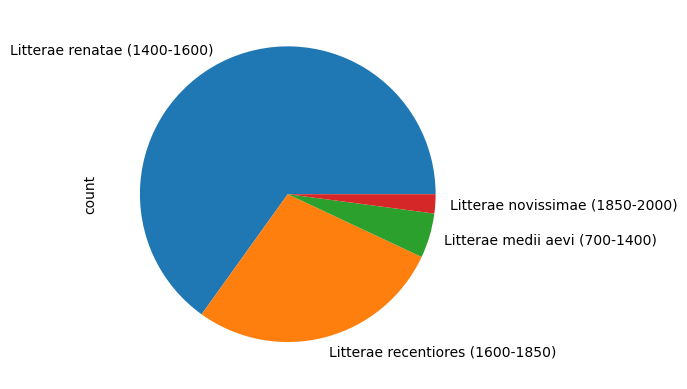

In [87]:
# Extract the value counts for the exploded 'period' column
periods_count = periods.value_counts()

# Find all rows in 'periods_count' where the index contains 'Litterae'
periods_count_litterae = periods_count[periods_count.index.str.contains("Litterae")]
print(periods_count_litterae)
print(periods_count_litterae.plot(kind="pie"))

period
Saeculum 16 (1501-1600)    282
Saeculum 15 (1401-1500)    106
Saeculum 18 (1701-1800)     83
Saeculum 17 (1601-1700)     50
Saeculum 19 (1801-1900)     31
Saeculum 11 (1001-1100)     13
Saeculum 14 (1301-1400)      8
Saeculum 20 (1901-2000)      8
Saeculum 12 (1101-1200)      6
Saeculum 13 (1201-1300)      4
Saeculum 10 (901-1000)       2
Name: count, dtype: int64
Axes(0.125,0.11;0.775x0.77)


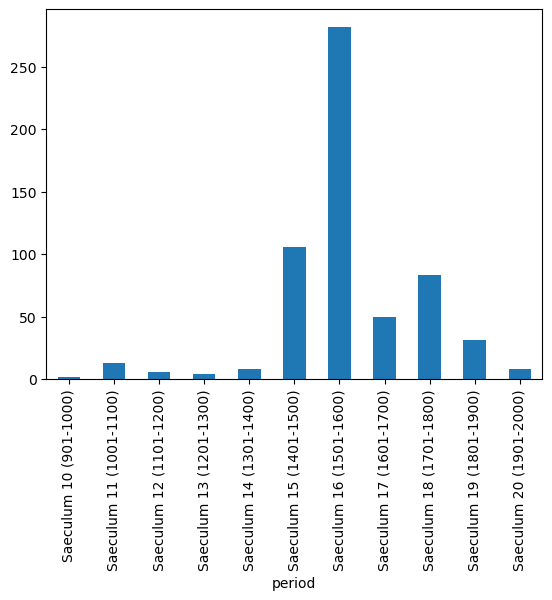

In [88]:
# Find all rows in 'periods_count' where the index contains 'Seculum'
periods_count_saecula = periods_count[periods_count.index.str.contains("Saeculum")]
print(periods_count_saecula)
# In additon, sorting by index to get the chronological order
print(periods_count_saecula.sort_index().plot(kind="bar"))

## Marko Marulić

The second part of this project is concerned with text analysis. For this purpose, we shall use the texts of Marko Marulić from CroALa. I consider Marulić to be a good choice for this task because there is enough material to work with (we saw that Marulić was well represented by both the number of documents and the number of words), his work is diverse enough to be able to do comparisons within a single author and last, but not least, he is one of the most important figures not only of Croatian Latin literature, but of the Croatian literature in general. Suffice to say he is, not without merit, titled ['the father of Croatian literature'](https://nsk.hr/en/news/croatia-marking-the-500th-anniversary-of-the-passing-of-the-father-of-croatian-literature/).

### Inspecting Marulić's works

Let's first find all the texts where Marulić is the main, i.e. first author.

In [28]:
# Whole table with rows where Marulić is the first author
marulus_df = croala_df.loc[croala_df['first_author'].str.contains("Marulić")]
marulus_df

,filename,titles,first_author,first_author_date,all_authors,editors,language,date,place,typus,genres,period,word_count
285,marul-mar-catull.xml,"Catulli carminis epitomae, versio electronica","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524, Marulić, Marko]",[Bratislav Lučin],[lat],[1517-1518],,prosa,[prosa oratio - epitome],"[Litterae renatae (1400-1600), Saeculum 16 (15...",1474
286,marul-mar-dante.xml,Principium operis Dantis Aligerii de Fluentino...,"Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524, Dante Alighieri; 1...","[Bratislav Lučin, Darko Novaković]",[lat],[1510],[Split],poesis,"[poesis - epica, poesis - versio, poesis - fra...","[Litterae renatae (1400-1600), Saeculum 16 (15...",953
287,marul-mar-dauid.xml,"Dauidias (1510–1517), versio electronica","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]","[Branimir Glavičić, Bratislav Lučin]",[lat],[1510-1517],,poesis,"[poesis - epica, prosa - epistula dedicatoria,...","[Litterae renatae (1400-1600), Saeculum 16 (15...",45403
288,marul-mar-dial.xml,"Dialogvs de Hercule a Christicolis superato, v...","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524, Marulić, Marko]",[Branimir Glavičić],[lat],[1519-1520],,prosa,[prosa oratio - dialogus],"[Litterae renatae (1400-1600), Saeculum 16 (15...",8236
289,marul-mar-epist-1477.xml,"Ad Georgium Sisgoreum epistula (1465-1466), ve...","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]","[Veljko Gortan, Vladimir Vratović]","[lat, lat, lat]",[1465-1466],,prosa,[prosa oratio - epistula],"[Litterae renatae (1400-1600), Saeculum 15 (14...",214
290,marul-mar-epist-1496-05-10.xml,Venerabili pręsbitero Brachiensi Marco Prodich...,"Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]","[Branimir Glavičić, Bratislav Lučin]",[lat],[1496-05-10],[Split],prosa,[prosa oratio - epistula],"[Litterae renatae (1400-1600), Saeculum 15 (14...",153
291,marul-mar-epist-1502-03-03.xml,Reuerendo in Christo pręsbitero Iacobo Grasola...,"Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]","[Branimir Glavičić, Bratislav Lučin]",[lat],[1502-03-03],[Split],prosa,[prosa oratio - epistula],"[Litterae renatae (1400-1600), Saeculum 15 (14...",772
292,marul-mar-epist-1502x.xml,Reuerendo in Christo Domino Iacobo Grassolario...,"Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]","[Branimir Glavičić, Bratislav Lučin]",[lat],[1502-1507? 08-25],[Split],prosa,[prosa oratio - epistula],"[Litterae renatae (1400-1600), Saeculum 15 (14...",150
293,marul-mar-epist-1507-04-04.xml,Reuerendo in Christo Domino Iacobo Grassolario...,"Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]","[Branimir Glavičić, Bratislav Lučin]",[lat],[1507-04-04],[Split],prosa,[prosa oratio - epistula],"[Litterae renatae (1400-1600), Saeculum 15 (14...",325
294,marul-mar-epist-1515-04-26.xml,"Iacobo Grassolario, iuris pontificii consulto,...","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]","[Branimir Glavičić, Bratislav Lučin]",[lat],[1515-04-26],[Split],prosa,[prosa oratio - epistula],"[Litterae renatae (1400-1600), Saeculum 15 (14...",267


Let's now separate Marulić's work by 'typus'. Let's look at how many works are there and how many words do they contain.

In [29]:
print(f"Total number of works by Marulić is {len(marulus_df)} and the total number of words in his works is {marulus_df['word_count'].sum()}.", "\n")
print("Number of Marulić's prose vs. poetry works:", "\n", marulus_df['typus'].value_counts(), "\n")
print("Number of words in Marulić's prose vs. poetry works:", "\n", marulus_df.groupby('typus')['word_count'].sum())

Total number of works by Marulić is 33 and the total number of words in his works is 921827. 

Number of Marulić's prose vs. poetry works: 
 typus
prosa     20
poesis    13
Name: count, dtype: int64 

Number of words in Marulić's prose vs. poetry works: 
 typus
poesis     59913
prosa     861914
Name: word_count, dtype: int64


There is considerably more material in prose works, as we can see. We should now introduce some latinist knowledge. If we further investigate Marulić's poetry (see the table bellow), we can see that most of the words belong to 'Dauidias', which, while properly marked with the 'poesis' typus, is in fact *epic* poetry and thus considerably differs from all other 'smaller' poems (like 'carmina', 'epigrammata' etc.). Any proper latinist would frown upon us grouping these together and analyzing them like a homogenous group. 

In [30]:
marulus_df.sort_values(by="word_count", ascending=False)

,filename,titles,first_author,first_author_date,all_authors,editors,language,date,place,typus,genres,period,word_count
302,marul-mar-repert.xml,"Repertorium, versio electronica","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524, Plinio, Strabone, ...",[Branimir Glavičić],[lat],[c. 1480 - c. 1520],,prosa,[prosa oratio - loci communes],"[Litterae renatae (1400-1600), Saeculum 16 (15...",316492
299,marul-mar-inst.xml,De institutione bene vivendi per exempla sanct...,"Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]",[Branimir Glavičić],[lat],[1496-1499],[Split],prosa,[prosa oratio - tractatus],"[Litterae renatae (1400-1600), Saeculum 15 (14...",187438
296,marul-mar-euang.xml,"Evangelistarium (ante 1516), versio electronica","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]",[Neven Jovanović],[lat],[ante 1516],,prosa,[prosa oratio - tractatus],"[Litterae renatae (1400-1600), Saeculum 16 (15...",155646
297,marul-mar-humil.xml,"De humilitate, versio electronica","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524, Consorti, Francesco]",[Branimir Glavičić],[lat],[1519],,prosa,"[prosa oratio - tractatus, prosa oratio - para...","[Litterae renatae (1400-1600), Saeculum 16 (15...",81648
287,marul-mar-dauid.xml,"Dauidias (1510–1517), versio electronica","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]","[Branimir Glavičić, Bratislav Lučin]",[lat],[1510-1517],,poesis,"[poesis - epica, prosa - epistula dedicatoria,...","[Litterae renatae (1400-1600), Saeculum 16 (15...",45403
305,marul-mar-vir-ill.xml,"De Veteris instrumenti uiris illustribus, vers...","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524, Marulić, Marko, No...",[Branimir Glavičić],[lat],[1517-1518],,prosa,[prosa oratio - vita],"[Litterae renatae (1400-1600), Saeculum 16 (15...",29810
298,marul-mar-in-epigr.xml,In epigrammata priscorum commentarius,"Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]",[Bratislav Lučin],[lat],[1503–1510],,prosa,[prosa oratio - commentarius],"[Litterae renatae (1400-1600), Saeculum 16 (15...",25304
304,marul-mar-ult-iudic.xml,"De ultimo Christi iudicio sermo, versio electr...","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524, Marulić, Marko]",[Branimir Glavičić],[lat],[1520-1521],,prosa,[prosa oratio - sermo],"[Litterae renatae (1400-1600), Saeculum 16 (15...",16878
300,marul-mar-quinqu.xml,"Quinquaginta parabolae (ante 1517), versio ele...","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]",[Branimir Glavičić],[lat],[1517],,prosa,[prosa oratio - parabola],"[Litterae renatae (1400-1600), Saeculum 16 (15...",13330
306,marul-mar-vita.xml,"Vita diui Hieronymi, versio electronica","Marulić, Marko",1450-1524,"[Marulić, Marko; 1450-1524]",[Darko Novaković],[lat],[1507],,prosa,[prosa oratio - vita],"[Litterae renatae (1400-1600), Saeculum 16 (15...",10679


### Text analysis - *De Veteris instrumenti uiris illustribus* and *Dauidias*

We see that comparing poetry and prose could lead to dubious results (because of different sizes of these 'subcorpora') and analyzing all 33 works by Marulić would be time and resource consuming. So let's adopt a different approach. To keep the size of this project reasonable, we will choose two texts and compare them. Combining domain knowledge and data inspection once again, I'm choosing to work with *De Veteris instrumenti uiris illustribus* and *Dauidias*. First is a prose work, a 29810 words large collection of short biographies of Old Testament characters. We shall compare this to *Dauidias* an epic poem recounting the life of king David and consisting of 45403 words. While the works still differ in size, I think the topical similarity between the two might yield interesting results and they are could both be considered important in Marulić's *opus* in general.

How shall we proceed with analyzing the texts? First, let's extract them from the XML files.

In [31]:
# Creating an XML object of 'De Veteris'
uir_ill_doc = read_tei("txts/marul-mar-vir-ill.xml")
# Extracting the text of 'De Veteris'
uir_ill_txt = e2t(uir_ill_doc.find("text"))

In [32]:
dauidias_doc = read_tei("txts/marul-mar-dauid.xml")
# Because 'Daudias' is an epic poem, the text element is structured in lines.
# For this reason, using the 'e2t' function, returns a messy version of the text (it glues the last word of a line to the first word of the next one)
# We adopt a different approach, using a loop and the regex
dauidias_txt = ""
for l in dauidias_doc.select("text"):
    dauidias_txt = re.sub(r'\s+', ' ', l.getText())

There is a number of possible options for analyzing Latin texts in Python. The usual, out-of-the-box soultions, like *NLTK* or *SpaCy* don't work without some additinal tweaking. I took three different possibilities into consideration: *CLTK*, *LatinCy* and *UDPipe*. Following advice given by prof. Margherita Fantoli and inspecting all three, I chose to work with *UDPipe*.

Here's why I opted for *UDPipe*. [*CLTK*](https://docs.cltk.org/) seemed like an easy to use choice, because it can be simply imported as Python library and used. However, it seems to rely on accessing online GPT models for its backend a lot, which is something I would like to avoid and it wasn't recommended by prof. Fantoli. [*LatinCy*](https://spacy.io/universe/project/latincy) is 'a set of Latin-language core pipelines for use with spaCy', which could also work pretty well, but I ran into problems while trying to install the 'wheel' needed to use these Latin models in spaCy. This is why I chose to work with [*UDPipe*](https://lindat.mff.cuni.cz/services/udpipe/), which offers a lot of models to choose from and has an API, thus eliminating the need to install and import a lot of tools locally.

We will first inpect which models for Latin exist by sending a request to the `models` endpoint.

In [33]:
response = requests.get("https://lindat.mff.cuni.cz/services/udpipe/api/models")
ud_data = json.loads(response.text)

In [34]:
for model in ud_data['models']:
    if model.startswith("latin"):
        print (model)

latin-ittb-ud-2.17-251125
latin-circse-ud-2.17-251125
latin-llct-ud-2.17-251125
latin-perseus-ud-2.17-251125
latin-proiel-ud-2.17-251125
latin-udante-ud-2.17-251125
latin-ittb-ud-2.15-241121
latin-llct-ud-2.15-241121
latin-perseus-ud-2.15-241121
latin-proiel-ud-2.15-241121
latin-udante-ud-2.15-241121
latin-evalatin24-240520
latin-ittb-ud-2.12-230717
latin-llct-ud-2.12-230717
latin-perseus-ud-2.12-230717
latin-proiel-ud-2.12-230717
latin-udante-ud-2.12-230717
latin-ittb-ud-2.10-220711
latin-llct-ud-2.10-220711
latin-perseus-ud-2.10-220711
latin-proiel-ud-2.10-220711
latin-udante-ud-2.10-220711
latin-ittb-ud-2.6-200830
latin-llct-ud-2.6-200830
latin-proiel-ud-2.6-200830
latin-perseus-ud-2.6-200830
latin-evalatin20-200830
latin-ittb-ud-2.5-191206
latin-proiel-ud-2.5-191206
latin-perseus-ud-2.5-191206
latin-ittb-ud-2.4-190531
latin-proiel-ud-2.4-190531
latin-perseus-ud-2.4-190531
latin-ud-2.0-170801
latin-ittb-ud-2.0-170801
latin-proiel-ud-2.0-170801
latin-ud-1.2-160523
latin-itt-ud-1.2-16

Following a quick research of the models, I chose [*EvaLatin24*](https://github.com/ufal/evalatin2024-latinpipe) to tokenize, lemmatize and tag our texts. We can do this by passing the right parameters to a different endpoint (`process`). We specify the `model`, mark that we want the text tokenized and POS tagged by using the `tokenizer` and `tagger` parameters and specifying the text in the `data` parameter. We ommit the `parser` because we are not interested in dependency parsing.

**NOTE:** My *Jupyter* notebook reported the following issue when trying to 'post' our texts to the '`process`' endpoint:

    IOPub data rate exceeded. The Jupyter server will temporarily stop sending output to the client in order to avoid crashing it. To change this limit, set the config variable --ServerApp.iopub_data_rate_limit.
    Current values:
    ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
    ServerApp.rate_limit_window=3.0 (secs)

To fix this, try running Jupyter with the following command:

    jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [35]:
# Set paratmeters for 'De Veteris'
params_uir_ill = {
    "model": "latin-evalatin24-240520",
    "tokenizer": "tokenize",
    "tagger": "tag",
    "data": uir_ill_txt
}

In [36]:
# Post the text to API to be analyzed
uir_ill_json = json.loads(requests.post("https://lindat.mff.cuni.cz/services/udpipe/api/process", data=params_uir_ill).text)

In [37]:
print(uir_ill_json.keys())

dict_keys(['model', 'acknowledgements', 'result'])


Our text is analyzed and stored inside a JSON object, under the 'result' key. I am avoiding printing out the results here (although I did print them at first to inspect them), because they are quite large and doing so would make using this notebook a less pleasurable experience. If you do not wish to print out the result, you can see what the output for the first sentence looks like [here](https://lindat.mff.cuni.cz/services/udpipe/api/process?model=latin-evalatin24-240520&tokenizer&tagger&data=Divi%20Hieronymi%20de%20uiris%20illustribus%20librum%20nuper%20euoluenti%20mihi%20uenit%20in%20mentem%20illius%20ea%20in%20re%20studium%20pro%20uiribus%20emulari%20uelle.) (the link leads to a direct API URL for the first sentence).

First I'll save the text to `tsv` file. This is not necessary for this project specifically, but it's nice to store the results (and make them visible on the GitHub repo).

Next, I want to extract only the tokens with their lemmas and POS tags. To do this, I'll turn the lines from the the results to a list and then filter out the lines starting with '#'. These lines are contain everything we **do not** want to keep, so eliminating them will leave us with tokens.

In [38]:
with open ("vir-ill.tsv", "w", encoding="utf-8") as f:
    f.write(uir_ill_json['result'])

In [39]:
# Split the results by lines
lines_uir_ill = uir_ill_json['result'].splitlines()
tags_uir_ill =[]
# Pick out only lines not starting wiht '#'
for l in lines_uir_ill:
    if not l.startswith('#'):
        tags_uir_ill.append(l)
# Inspect the first five tags.
tags_uir_ill[:20]

['1\tDE\tde\tADP\t_\t_\t_\t_\t_\t_',
 '2\tVETERIS\tueterus\tADJ\t_\tCase=Abl|Gender=Masc|InflClass=IndEurO|Number=Plur\t_\t_\t_\t_',
 '3\tINSTRVMENTI\tINSTRVMENTI\tVERB\t_\tAspect=Perf|Case=Abl|Gender=Masc|InflClass=LatX|InflClass[nominal]=IndEurO|Number=Plur|VerbForm=Part|Voice=Pass\t_\t_\t_\t_',
 '4\tVIRIS\tvirus\tNOUN\t_\tCase=Abl|Gender=Masc|InflClass=IndEurO|Number=Plur\t_\t_\t_\t_',
 '5\tILLVSTRIBV\tillvstribv\tNOUN\t_\t_\t_\t_\t_\tSpaceAfter=No',
 '6\tS\tS\tADJ\t_\t_\t_\t_\t_\t_',
 '7\tM\tM\tPROPN\t_\tAbbr=Yes\t_\t_\t_\tSpaceAfter=No',
 '8\t.\t.\tPUNCT\t_\t_\t_\t_\t_\t_',
 '9\tMARVLI\tmarvlus\tPROPN\t_\tCase=Gen|Gender=Masc|InflClass=IndEurO|Number=Sing\t_\t_\t_\t_',
 '10\tCOMMENTARIVM.Divi\tcommentarivm.divus\tADJ\t_\tCase=Gen|Gender=Masc|InflClass=IndEurO|Number=Sing\t_\t_\t_\t_',
 '11\tHieronymi\thieronymus\tPROPN\t_\tCase=Gen|Gender=Masc|InflClass=IndEurO|Number=Sing\t_\t_\t_\t_',
 '12\tde\tde\tADP\t_\t_\t_\t_\t_\t_',
 '13\tuiris\tuir\tNOUN\t_\tCase=Abl|Gender=Masc|InflClass

Now we turn the list into a string. We make use of the `io` library so we can read the string into a PD dataframe.

In [40]:
tags_uir_ill_string = '\n'.join(tags_uir_ill)
tags_uir_ill_string = StringIO(tags_uir_ill_string)
uir_ill_df = pd.read_csv(tags_uir_ill_string, sep="\t", names=['sent_#,', 'token', 'lemma', 'POS', 'morph', '1', '2', '3', '4', '5'])

In [41]:
uir_ill_df.head(50)

,"sent_#,",token,lemma,POS,morph,1,2,3,4,5
0,1,DE,de,ADP,_,_,_,_,_,_
1,2,VETERIS,ueterus,ADJ,_,Case=Abl|Gender=Masc|InflClass=IndEurO|Number=...,_,_,_,_
2,3,INSTRVMENTI,INSTRVMENTI,VERB,_,Aspect=Perf|Case=Abl|Gender=Masc|InflClass=Lat...,_,_,_,_
3,4,VIRIS,virus,NOUN,_,Case=Abl|Gender=Masc|InflClass=IndEurO|Number=...,_,_,_,_
4,5,ILLVSTRIBV,illvstribv,NOUN,_,_,_,_,_,SpaceAfter=No
5,6,S,S,ADJ,_,_,_,_,_,_
6,7,M,M,PROPN,_,Abbr=Yes,_,_,_,SpaceAfter=No
7,8,.,.,PUNCT,_,_,_,_,_,_
8,9,MARVLI,marvlus,PROPN,_,Case=Gen|Gender=Masc|InflClass=IndEurO|Number=...,_,_,_,_
9,10,COMMENTARIVM.Divi,commentarivm.divus,ADJ,_,Case=Gen|Gender=Masc|InflClass=IndEurO|Number=...,_,_,_,_


Now we can repeat the procedure for *Dauidias*.

In [42]:
# Accessing API fo 'Dauidias'
params_dauidias = {
    "model": "latin-evalatin24-240520",
    "tokenizer": "tokenize",
    "tagger": "tag",
    "data": dauidias_txt
}

dauidias_json = json.loads(requests.post("https://lindat.mff.cuni.cz/services/udpipe/api/process", data=params_dauidias).text)

In [43]:
# Processing 'Dauidias'

with open ("dauidias.tsv", "w", encoding="utf-8") as f:
    f.write(dauidias_json['result'])

lines_dauidias = dauidias_json['result'].splitlines()
tags_dauidias =[]

for l in lines_dauidias:
    if not l.startswith('#'):
        tags_dauidias.append(l)

for i in range(len(tags_dauidias)):
    if re.search(r'\t\".*\t[a-z]', tags_dauidias[i]):
        tags_dauidias[i] = re.sub(r'(\t".*)\t([a-z].*)', r'\1\t"\2', tags_dauidias[i])

for i in range(len(tags_dauidias)):
    if '"Anne' in tags_dauidias[i]:
        tags_dauidias[i] = re.sub(r'"Anne\t', r'"Anne\t"', tags_dauidias[i])

In [44]:
tags_dauidias[44611]

'12-13\t"Anne\t"_\t_\t_\t_\t_\t_\t_\t_'

In [45]:
for l in tags_dauidias:
    if "\"" in l and "10" in l:
        print (l)

10	"Quam	"quam	SCONJ	_	PronType=Rel	_	_	_	_
10	"	"	PUNCT	_	_	_	_	_	_
10	"Testor	"testor	VERB	_	Aspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin|Voice=Pass	_	_	_	SpaceAfter=No
10	"est	"esum	AUX	_	Aspect=Imp|InflClass=LatAnom|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin	_	_	_	_
10	"	"	PUNCT	_	_	_	_	_	_
10	"	"	PUNCT	_	_	_	_	_	_
10	"	"	PUNCT	_	_	_	_	_	_
10	"Quid	"quid	ADV	_	PronType=Rel	_	_	_	_
10	"Ioabus	"ioabus	PROPN	_	Foreign=Yes|Gender=Masc|NameType=Giv|Number=Sing	_	_	_	SpaceAfter=No
10	"	"	PUNCT	_	_	_	_	_	_
10	"	"	PUNCT	_	_	_	_	_	_
10	"	"	PUNCT	_	_	_	_	_	_
10	"quod	"quod	SCONJ	_	PronType=Rel	_	_	_	_
10	"	"	PUNCT	_	_	_	_	_	_


In [46]:
# Creating a DF
tags_dauidias_string = '\n'.join(tags_dauidias)
tags_dauidias_string = StringIO(tags_dauidias_string)
dauidias_df = pd.read_csv(tags_dauidias_string, 
                          sep="\t", 
                          names=['sent_#,', 'token', 'lemma', 'POS', 'morph', '1', '2', '3', '4', '5'])

While creating the *Dauidias* dataframe we ran in to some trouble reading certain rows. For some reason, certain elements from the 'tags_dauidias' list (like `11464`) cannot be read, due to unexpected formating. It seems the problems stem from rows in which the quotation mark (`"`) wasn't properly tokenized and tagged, but cleaning this would require a project of it's own. For this reason I will simply skip all rows with errors. While this seems 

In [47]:
(len(tags_dauidias) - len(dauidias_df))
#These are blank lines

3044